# Estimates Analysis

TBA 

Conclusions:

TBA

## Data and Methodology

Datasources:

* EPS Consensus values (Estimize consensuses.csv)
* Asset historical prices (Zipline.io/Quandl prices dataset)
* SPY historical prices (Yahoo Finance)


In [1]:
# Imports

from datetime import timedelta
from IPython.display import display, HTML, Markdown
import logging.config
import math
import os
import sys

from injector import Injector
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import mstats
import statsmodels.api as sm

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from estimize.logging import configure_logging
from estimize.di.default_module import DefaultModule
from estimize.services import (
    AssetService, AssetInfoService, CalendarService, EstimatesService, 
    EstimizeConsensusService, EventStudyService, MarketCapService, ReleasesService
)
from estimize.pandas import dfutils

configure_logging('ERROR')

injector = Injector([DefaultModule])
asset_service = injector.get(AssetService)
asset_info_service = injector.get(AssetInfoService)
calendar_service = injector.get(CalendarService)
estimates_service = injector.get(EstimatesService)
releases_service = injector.get(ReleasesService)
estimize_consensus_service = injector.get(EstimizeConsensusService)


In [2]:
def get_estimates(start_date, end_date):
    rdf = releases_service.get_releases(start_date, end_date)
    rdf.reset_index(inplace=True)
    rdf = rdf[rdf['estimize.eps'].notnull()]
    rdf = rdf[rdf['reported.eps'].notnull()]
    rdf.set_index('asset', inplace=True)
    
    adf = asset_info_service.get_asset_info()[['industry', 'sector']]
    rdf = rdf.join(adf, how='inner')
    rdf.reset_index(inplace=True)
    rdf.set_index('release_id', inplace=True)
    
    df = estimates_service.get_estimates()
    df.reset_index(inplace=True)
    df.set_index('release_id', inplace=True)
    df = df[df['flagged'] == False]
    
    df = df.join(rdf, how='inner')
    df.reset_index(inplace=True)
    df.set_index(['asset', 'fiscal_year', 'fiscal_quarter'], inplace=True)
    
    cdf = estimize_consensus_service.get_final_consensuses(start_date, end_date)
    cdf.reset_index(inplace=True)
    cdf.set_index(['asset', 'fiscal_year', 'fiscal_quarter'], inplace=True)
    
    df = df.join(cdf, how='inner', rsuffix='_right')
    df.reset_index(inplace=True)
    
    df = df[['as_of_date', 'created_at', 'reports_at_date', 'bmo', 'sector', 'industry', 'asset', 'release_id', 'user_id', 'eps', 'estimize.eps.mean', 'estimize.eps.sd', 'estimize.eps.weighted', 'wallstreet.eps', 'actual.eps']]
    df['eps'] = mstats.winsorize(df['eps'], limits=[0.01, 0.01])
    
    return df

def get_estimate_factors(df):
    df = df.copy()
    df['error_z_score'] = (df['eps'] - df['actual.eps']) / (df['estimize.eps.sd'] + 0.01)
    df['eps_z_score'] = (df['eps'] - df['estimize.eps.mean']) / (df['estimize.eps.sd'] + 0.01)
    df['ttr'] = df['as_of_date'].subtract(df['created_at']).dt.total_seconds() / timedelta(days=1).total_seconds()
    df = df[df['ttr'] > 0]
    df.dropna(subset=['error_z_score', 'eps_z_score'], inplace=True)
    
    df['error_z_score'] = mstats.winsorize(df['error_z_score'], limits=[0.01, 0.01])
    df['eps_z_score'] = mstats.winsorize(df['eps_z_score'], limits=[0.01, 0.01])
    
    return df

def get_factors(df, index):
    if index == 'user':
        column = 'user_id'
    else:
        column = index
        
    error_z_score_column = 'error_z_score_{}'.format(index)
            
    df = df.groupby([column, 'reports_at_date'])[['error_z_score']].agg(['sum', 'count'])
    df.columns = ['_'.join(x) for x in df.columns.ravel()]
    df.reset_index(inplace=True)
    df.set_index('reports_at_date', inplace=True)
    
    df = df.groupby(column)[['error_z_score_sum', 'error_z_score_count']].expanding().sum()
    df[error_z_score_column] = df['error_z_score_sum'] / df['error_z_score_count']
    df.drop(['error_z_score_sum', 'error_z_score_count'], axis=1, inplace=True)
    
    df.reset_index(inplace=True)
    df.set_index('reports_at_date', inplace=True)
    df[error_z_score_column] = df.groupby(column)[error_z_score_column].transform(lambda vals: vals.shift(1))
    df.fillna(0.0, inplace=True)
    
    df.reset_index(inplace=True)
    df.set_index(['reports_at_date', column], inplace=True)
    
    return df

def get_observations(start_date, end_date, direction=None):
    df = get_estimates(start_date, end_date)
    df = get_estimate_factors(df)
    
    if direction == 'positive':
        df = df[df['error_z_score'] > 0]
    elif direction == 'negative':
        df = df[df['error_z_score'] < 0]
        
    ufdf = get_factors(df, index='user')
    afdf = get_factors(df, index='asset')
    ifdf = get_factors(df, index='industry')
    sfdf = get_factors(df, index='sector')
    
    df.reset_index(inplace=True)
    df.set_index(['reports_at_date', 'sector'], inplace=True)
    df = df.join(sfdf, how='inner')

    df.reset_index(inplace=True)
    df.set_index(['reports_at_date', 'industry'], inplace=True)
    df = df.join(ifdf, how='inner')

    df.reset_index(inplace=True)
    df.set_index(['reports_at_date', 'asset'], inplace=True)
    df = df.join(afdf, how='inner')

    df.reset_index(inplace=True)
    df.set_index(['reports_at_date', 'user_id'], inplace=True)
    df = df.join(ufdf, how='inner')
    df.reset_index(inplace=True)
    
    return df


In [3]:
start_date = '2012-01-01'
end_date = '2018-01-01'

odf = get_observations(start_date, end_date, direction=None)
print(len(odf))
print(odf.eps.min())
print(odf.eps.mean())
print(odf.eps.max())

# asset = asset_service.get_asset('AAPL')
# asset = asset_service.get_asset('AMZN')
# asset = asset_service.get_asset('FB')
# asset = asset_service.get_asset('GOOGL')
# odf = odf[odf['asset'] == asset]
# print(len(odf))

523749
-0.88
0.9022658443937114
8.09


## EPS Deltas

-9.26074331560925
-0.32801327610548386
8.982859418588


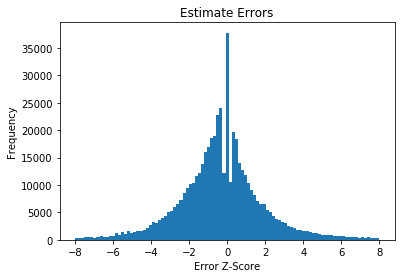

In [4]:
df = odf.copy()

# df['error_z_score'] = df['error_z_score_asset']
# df['error_z_score'] = df['error_z_score_industry']
# df['error_z_score'] = df['error_z_score_sector']

# df = df[df['error_z_score'] < 0]
# df['error_z_score'] = np.log(-1 * df['error_z_score'])

# df = df[df['error_z_score'] > 0]
# df['error_z_score'] = np.log(df['error_z_score'])

print(df.error_z_score.min())
print(df.error_z_score.mean())
print(df.error_z_score.max())

bins = np.linspace(-8, 8, 100)

plt.hist(df.error_z_score, bins)
plt.title("Estimate Errors")
plt.xlabel("Error Z-Score")
plt.ylabel("Frequency")
plt.show()


In [13]:
df = odf.copy()
# df = df[df['error_z_score'] < 0]
# df['error_z_score'] *= -1
# df['error_z_score'] = np.log(-1 * df['error_z_score'])

# df = df[df['error_z_score'] > 0]
# df['error_z_score'] = np.log(df['error_z_score'])

# df['error_z_score'] = mstats.winsorize(df['error_z_score'], limits=[0.001, 0.001])
# df['eps_z_score'] = mstats.winsorize(df['eps_z_score'], limits=[0.001, 0.001])
# df['error_z_score_user'] = mstats.winsorize(df['error_z_score_user'], limits=[0.001, 0.001])
# df['error_z_score_asset'] = mstats.winsorize(df['error_z_score_asset'], limits=[0.001, 0.001])
# df['error_z_score_industry'] = mstats.winsorize(df['error_z_score_industry'], limits=[0.001, 0.001])
# df['error_z_score_sector'] = mstats.winsorize(df['error_z_score_sector'], limits=[0.001, 0.001])

df['eps_z_score_2'] = df['eps_z_score'] * df['eps_z_score']
df['error_z_score_user_2'] = df['error_z_score_user'] * df['error_z_score_user']
# df['ttr'] = np.log(df['ttr'] + 1)

# model_columns = ['eps_z_score'] # R2 = 37.8%
# model_columns = ['eps_z_score_2', 'eps_z_score'] # R2 = 38.1%
# model_columns = ['error_z_score_user', 'eps_z_score_2', 'eps_z_score'] # R2 = 38.1%
# model_columns = ['error_z_score_asset', 'error_z_score_user', 'eps_z_score_2', 'eps_z_score'] # R2 = 40.0%
# model_columns = ['error_z_score_industry', 'error_z_score_asset', 'error_z_score_user', 'eps_z_score_2', 'eps_z_score'] # R2 = 40.1%
# model_columns = ['ttr', 'error_z_score_sector', 'error_z_score_industry', 'error_z_score_asset', 'error_z_score_user', 'eps_z_score_2', 'eps_z_score'] # R2 = 40.2%  
model_columns = ['ttr', 'error_z_score_user_2', 'error_z_score_sector', 'error_z_score_industry', 'error_z_score_asset', 'error_z_score_user', 'eps_z_score_2', 'eps_z_score'] # R2 = 40.2%  

value_column = 'error_z_score'

X = df[model_columns]
X = sm.add_constant(X)
y = df[value_column]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
# model = sm.GLM(y, X, family=sm.families.Tweedie(var_power=1.2, link_power=0)).fit()
# r2 = 1 - (model.deviance / model.null_deviance)
# print('r2: ', r2)
df['prediction'] = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())

p = model.params

# generate x-values for your regression line (two is sufficient)
x = np.arange(-6, 14)

# scatter-plot data
# ax = df.plot(x=model_columns[0], y=value_column, kind='scatter')
# bx = df.plot(x=model_columns[0], y='prediction', color='red', kind='scatter')

                            OLS Regression Results                            
Dep. Variable:          error_z_score   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                 4.392e+04
Date:                Mon, 09 Apr 2018   Prob (F-statistic):               0.00
Time:                        13:45:17   Log-Likelihood:            -1.1111e+06
No. Observations:              523749   AIC:                         2.222e+06
Df Residuals:                  523740   BIC:                         2.222e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0

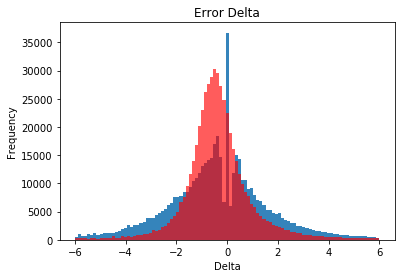

In [14]:
bins = np.linspace(-6, 6, 100)

plt.hist(df['error_z_score'], bins, alpha=0.90)
plt.hist(df['prediction'], bins, color='red', alpha=0.64)
plt.title("Error Delta")
plt.xlabel("Delta")
plt.ylabel("Frequency")
plt.show()

In [15]:
tdf = df[['release_id', 'prediction', 'eps', 'estimize.eps.sd', 'actual.eps', 'estimize.eps.weighted']].copy()
tdf['eps_delta_t'] = tdf['prediction'] * tdf['estimize.eps.sd']
tdf['eps_t'] = tdf['eps'] - tdf['eps_delta_t']
# display(tdf)

adf = tdf.groupby('release_id')['eps', 'eps_t', 'actual.eps', 'estimize.eps.weighted', 'estimize.eps.sd'].mean()
adf['eps_tw'] = (adf['eps_t'] + adf['eps'] + adf['estimize.eps.weighted']) / 3
# adf = adf.round(2)
# display(adf)
adf['eps_error'] = mstats.winsorize(np.abs(adf['actual.eps'] - adf['eps']), limits=[0.05, 0.05])
adf['eps_t_error'] = mstats.winsorize(np.abs(adf['actual.eps'] - adf['eps_t']), limits=[0.05, 0.05])
adf['eps_tw_error'] = mstats.winsorize(np.abs(adf['actual.eps'] - adf['eps_tw']), limits=[0.05, 0.05])
adf['eps_w_error'] = mstats.winsorize(np.abs(adf['actual.eps'] - adf['estimize.eps.weighted']), limits=[0.05, 0.05])
print(adf.eps.max())
print(adf.eps.mean())
print(adf.eps.min())
display(adf.mean())

nedf = adf[['eps_error', 'eps_w_error', 'eps_t_error', 'eps_tw_error', 'estimize.eps.sd']].copy()
nedf.reset_index(inplace=True)
nedf['eps_error'] = nedf['eps_error'] / (nedf['estimize.eps.sd'] + 0.01)
nedf['eps_w_error'] = nedf['eps_w_error'] / (nedf['estimize.eps.sd'] + 0.01)
nedf['eps_t_error'] = nedf['eps_t_error'] / (nedf['estimize.eps.sd'] + 0.01)
nedf['eps_tw_error'] = nedf['eps_tw_error'] / (nedf['estimize.eps.sd'] + 0.01)
nedf.dropna(inplace=True)
nedf = nedf.mean()
display(nedf)

# display(adf)

adf['am_win'] = adf['eps_error'] < adf['eps_t_error']
adf['at_win'] = adf['eps_error'] > adf['eps_t_error']

adf['bm_win'] = adf['eps_error'] < adf['eps_w_error']
adf['bw_win'] = adf['eps_error'] > adf['eps_w_error']

adf['ct_win'] = adf['eps_t_error'] < adf['eps_w_error']
adf['cw_win'] = adf['eps_t_error'] > adf['eps_w_error']

adf['dtw_win'] = adf['eps_tw_error'] < adf['eps_w_error']
adf['dw_win'] = adf['eps_tw_error'] > adf['eps_w_error']

print(adf.mean())


8.09000000000005
0.6449171200645819
-0.8800000000000006


eps                      0.644917
eps_t                    0.649918
actual.eps               0.651732
estimize.eps.weighted    0.638151
estimize.eps.sd          0.040724
eps_tw                   0.644391
eps_error                0.080356
eps_t_error              0.071831
eps_tw_error             0.072470
eps_w_error              0.069623
dtype: float64

release_id         77955.436344
eps_error              1.974674
eps_w_error            1.775527
eps_t_error            1.810043
eps_tw_error           1.827056
estimize.eps.sd        0.040724
dtype: float64

eps                      0.644917
eps_t                    0.649918
actual.eps               0.651732
estimize.eps.weighted    0.638151
estimize.eps.sd          0.040724
eps_tw                   0.644391
eps_error                0.080356
eps_t_error              0.071831
eps_tw_error             0.072470
eps_w_error              0.069623
am_win                   0.381413
at_win                   0.612381
bm_win                   0.387660
bw_win                   0.607786
ct_win                   0.476484
cw_win                   0.519083
dtw_win                  0.450691
dw_win                   0.545359
dtype: float64


In [68]:
import sklearn.neural_network as nn
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()

df = odf.copy()
print(len(df))

df['error_z_score_p'] = (df['error_z_score'] > 0) * 1.0
df['error_z_score_0'] = (df['error_z_score'] == 0) * 1.0
df['error_z_score_n'] = (df['error_z_score'] < 0) * 1.0
df['eps_z_score_2'] = df['eps_z_score'] * df['eps_z_score']

# model_columns = ['eps_z_score'] # R2 = ?%
# model_columns = ['eps_z_score', 'eps_z_score_2'] # R2 = ?%
# model_columns = ['error_delta_user', 'eps_z_score', 'eps_z_score_2'] # R2 = ?%
# model_columns = ['error_z_score_asset', 'eps_z_score_2', 'eps_z_score', 'error_z_score_user'] # R2 = 40.0%
model_columns = ['ttr', 'error_z_score_sector', 'error_z_score_industry', 'error_z_score_asset', 'error_z_score_user', 'eps_z_score_2', 'eps_z_score'] # R2 = ?%

# value_columns = ['error_z_score_p', 'error_z_score_n']
value_column = 'error_z_score'

train, test = np.split(df.sample(frac=1), [int(.8*len(df))])
print('train: ', len(train))
print('test: ', len(test))

X_train = train[model_columns]
scaler.fit(X_train)
X_train = scaler.transform(X_train)
y_train = train[value_column]

model = nn.MLPRegressor(
    hidden_layer_sizes=(8, 4),
    activation='tanh',
    solver='lbfgs',
    max_iter=1000,
    verbose=True
)

results = model.fit(X_train, y_train)

score_train = results.score(X_train, y_train)
print('train score: ', score_train)

# Test
X_test = test[model_columns]
X_test = scaler.transform(X_test)
y_test = test[value_column]

score_test = results.score(X_test, y_test)
print('test score: ', score_test)


200186
train:  160148
test:  40038
train score:  0.42276488966706816
test score:  0.42303757116630375


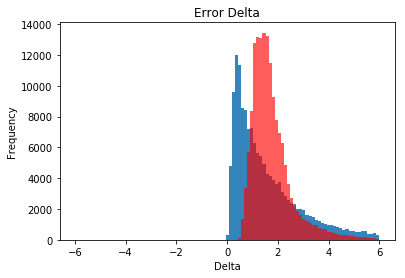

In [69]:
train['prediction'] = model.predict(X_train)

bins = np.linspace(-6, 6, 100)

plt.hist(train['error_z_score'], bins, alpha=0.90)
plt.hist(train['prediction'], bins, color='red', alpha=0.64)
plt.title("Error Delta")
plt.xlabel("Delta")
plt.ylabel("Frequency")
plt.show()

In [81]:
start_date = '2012-01-01'
end_date = '2018-01-01'

odf = get_observations(start_date, end_date, direction=None)
print(len(odf))
print(odf.eps.min())
print(odf.eps.mean())
print(odf.eps.max())

523749
-0.88
0.9022658443937114
8.09


In [84]:
import sklearn.neural_network as nn
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()

df = odf.copy()
print(len(df))

df['error_z_score_p'] = (df['error_z_score'] > 0) * 1.0
df['error_z_score_0'] = (df['error_z_score'] == 0) * 1.0
df['error_z_score_n'] = (df['error_z_score'] < 0) * 1.0
df['eps_z_score_2'] = df['eps_z_score'] * df['eps_z_score']

# model_columns = ['eps_z_score'] # R2 = ?%
# model_columns = ['eps_z_score', 'eps_z_score_2'] # R2 = ?%
# model_columns = ['error_delta_user', 'eps_z_score', 'eps_z_score_2'] # R2 = ?%
# model_columns = ['error_z_score_asset', 'eps_z_score_2', 'eps_z_score', 'error_z_score_user'] # R2 = 40.0%
model_columns = ['ttr', 'error_z_score_sector', 'error_z_score_industry', 'error_z_score_asset', 'error_z_score_user', 'eps_z_score_2', 'eps_z_score'] # R2 = ?%

# value_columns = ['error_z_score_p', 'error_z_score_n']
value_column = 'error_z_score'

train, test = np.split(df.sample(frac=1), [int(.8*len(df))])
print('train: ', len(train))
print('test: ', len(test))

X_train = train[model_columns]
scaler.fit(X_train)
X_train = scaler.transform(X_train)
y_train = train[value_column]

model = nn.MLPRegressor(
    hidden_layer_sizes=(12, 6, 3),
    activation='tanh',
    solver='lbfgs',
    max_iter=4000,
    verbose=True
)

results = model.fit(X_train, y_train)

score_train = results.score(X_train, y_train)
print('train score: ', score_train)

# Test
X_test = test[model_columns]
X_test = scaler.transform(X_test)
y_test = test[value_column]

score_test = results.score(X_test, y_test)
print('test score: ', score_test)


523749
train:  418999
test:  104750
train score:  0.4235300215846998
test score:  0.41970968741132264


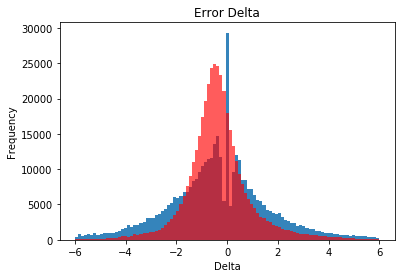

In [86]:
train['prediction'] = model.predict(X_train)

bins = np.linspace(-6, 6, 100)

plt.hist(train['error_z_score'], bins, alpha=0.90)
plt.hist(train['prediction'], bins, color='red', alpha=0.64)
plt.title("Error Delta")
plt.xlabel("Delta")
plt.ylabel("Frequency")
plt.show()